In [86]:
from paths import *
import pandas as pd
from model_dataset import Normalizer, DeNormalizer, TokenMap, WordDictionary
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import DataLoader, random_split
from model_dataset import TargetVowelDatasetPhoneseq as ThisDataset
from model_dataset import MelSpecTransformDB as TheTransform
from model_dataset import SilenceSampler_for_TV
from model_dataset import HarmonicNoiseGen
import torch
import torch.nn as nn
import torchaudio
import random
import numpy as np

In [2]:
REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64
BATCH_SIZE = 1
LOADER_WORKER = 32

In [3]:
target_path = src_

In [93]:
t_set = pd.read_csv(os.path.join(target_path, f"phi-T-guide.csv"))
st_set = pd.read_csv(os.path.join(target_path, f"phi-ST-guide.csv"))
integrated = pd.concat([t_set, st_set], ignore_index=True, sort=False)

In [128]:
def norm_mvn_manual(mel_spec, mean, std):
    eps = 1e-9
    norm_spec = (mel_spec - mean) / (std + eps)
    return norm_spec

def mv_get(mel_spec):
    mel_spec = mel_spec.squeeze(0)
    mean = mel_spec.mean()
    std = mel_spec.std(unbiased=False)
    return mean, std

def norm_mvn(mel_spec):
    eps = 1e-9
    mean = mel_spec.mean()
    std = mel_spec.std(unbiased=False)
    norm_spec = (mel_spec - mean) / (std + eps)
    return norm_spec

In [129]:
class MelSpecTransformNoNorm(nn.Module): 
    def __init__(self, sample_rate, n_fft=400, n_mels=64): 
        super().__init__()
        self.sample_rate = sample_rate
        n_stft = int((n_fft//2) + 1)
        self.transform = torchaudio.transforms.MelSpectrogram(sample_rate, n_mels=n_mels, n_fft=n_fft, hop_length=32)
        self.inverse_mel = torchaudio.transforms.InverseMelScale(sample_rate=sample_rate, n_mels=n_mels, n_stft=n_stft)
        self.grifflim = torchaudio.transforms.GriffinLim(n_fft=n_fft)
        self.amplitude_to_DB = torchaudio.transforms.AmplitudeToDB(stype='power')

    def forward(self, waveform): 
        # transform to mel_spectrogram
        mel_spec = self.transform(waveform)  # (channel, n_mels, time)
        # mel_spec = F.amplitude_to_DB(mel_spec)
        mel_spec = self.amplitude_to_DB(mel_spec)
        # mel_spec = torch.tensor(librosa.power_to_db(mel_spec.squeeze().numpy()))
        mel_spec = mel_spec.squeeze()
        mel_spec = mel_spec.permute(1, 0) # (F, L) -> (L, F)
        return mel_spec

In [130]:
mytrans_nonorm = MelSpecTransformNoNorm(sample_rate=REC_SAMPLE_RATE, 
                    n_fft=N_FFT, n_mels=N_MELS)

In [131]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title, fontsize=24)
    ax.set_ylabel(ylabel, fontdict={"fontsize": 18})
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontsize(18) for label in labels]
    # ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")

def plot_spectrogram_lined(specgram, title=None, ylabel="freq_bin", ax=None, flines=None, dlines=None, dlines2=None, burstlines=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title, fontsize=24)
    ax.set_ylabel(ylabel, fontdict={"fontsize": 18})
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontsize(18) for label in labels]
    
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")
    
    # Draw vertical lines at specified x-values
    if flines is not None:
        for x in flines:
            ax.axvline(x=x, color='red', linestyle='-', linewidth=2)
    if dlines is not None:
        for x in dlines:
            ax.axvline(x=x, color='blue', linestyle='--', linewidth=1)
    if dlines2 is not None:
        for x in dlines2:
            ax.axvline(x=x, color='orange', linestyle='--', linewidth=1)
    if burstlines is not None:
        for x in burstlines:
            ax.axvline(x=x, color='purple', linestyle='dashdot', linewidth=1)

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, flines=None, dlines=None, dlines2=None, burstlines=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    # Draw vertical lines at specified x-values
    ax = axes[0]
    if flines is not None:
        for x in flines:
            ax.axvline(x=x, color='red', linestyle='-', linewidth=2)
    if dlines is not None:
        for x in dlines:
            ax.axvline(x=x, color='blue', linestyle='--', linewidth=1)
    if dlines2 is not None:
        for x in dlines2:
            ax.axvline(x=x, color='orange', linestyle='--', linewidth=1)
    if burstlines is not None:
        for x in burstlines:
            ax.axvline(x=x, color='purple', linestyle='dashdot', linewidth=1)
    

def frame_to_time(frame_index, sr=16000, hop_length=200):
    return frame_index * hop_length / sr

In [135]:
phone_rec_dir = train_cut_phone_
check_dir = os.path.join(model_save_, "C_0Tg-0915163757-5", "guides")

In [136]:
st_guide = pd.read_csv(os.path.join(check_dir, "ST-valid.csv"))

In [137]:
picked_idx = random.randint(0, len(st_guide)-1)

In [138]:
noise_gen = HarmonicNoiseGen(sample_rate=16000, 
                                amplitude_scale=0.004, 
                                oscillation_scale=0.0006, f_0=50)
silence_duration = SilenceSampler_for_TV(fixlength=False).sample(len(st_guide))
noise_set = noise_gen.generate_samples(np.array(silence_duration))

HarmonicNoiseGen: sample_rate=16000, amplitude_scale=0.004, oscillation_scale=0.0006, f_0=50


In [139]:
def get_audio_st(pre_, stop_, vowel_, src_dir=phone_rec_dir): 
    S_name = os.path.join(
        src_dir, 
        pre_
    )
    T_name = os.path.join(
        src_dir, 
        stop_
    )
    V_name = os.path.join(
        src_dir, 
        vowel_
    )

    S_data, sample_rate_S = torchaudio.load(S_name, normalize=True)
    T_data, sample_rate_T = torchaudio.load(T_name, normalize=True)
    V_data, sample_rate_V = torchaudio.load(V_name, normalize=True)
    assert sample_rate_S == sample_rate_T == sample_rate_V

    data = torch.cat([S_data, T_data, V_data], dim=1)
    return data

def get_audio_tt(pre_sound, stop_, vowel_, src_dir=phone_rec_dir): 
    T_name = os.path.join(
        src_dir, 
        stop_
    )
    V_name = os.path.join(
        src_dir, 
        vowel_
    )

    # S_data, sample_rate_S = torchaudio.load(S_name, normalize=True)
    S_data = pre_sound
    T_data, sample_rate_T = torchaudio.load(T_name, normalize=True)
    V_data, sample_rate_V = torchaudio.load(V_name, normalize=True)
    assert sample_rate_T == sample_rate_V

    data = torch.cat([S_data, T_data, V_data], dim=1)
    return data

In [141]:
picked_idx = random.randint(0, len(st_guide)-1)

st_audio = get_audio_st(st_guide.iloc[picked_idx]["pre_path"], st_guide.iloc[picked_idx]["stop_path"], st_guide.iloc[picked_idx]["vowel_path"])
tt_audio = get_audio_tt(noise_set[picked_idx], st_guide.iloc[picked_idx]["stop_path"], st_guide.iloc[picked_idx]["vowel_path"])

st_spec_nonorm = mytrans_nonorm(st_audio)
tt_spec_nonorm = mytrans_nonorm(tt_audio)

mean, std = mv_get(st_spec_nonorm)
st_spec_newnorm = norm_mvn_manual(st_spec_nonorm, mean, std)
tt_spec_newnorm = norm_mvn_manual(tt_spec_nonorm, mean, std)

st_spec = norm_mvn(st_spec_nonorm)
tt_spec = norm_mvn(tt_spec_nonorm)


# plot_spectrogram(st_spec.T, title=f"Spectrogram")
# plot_spectrogram(tt_spec.T, title=f"Spectrogram")

# plot_spectrogram(st_spec_nonorm.T, title=f"Spectrogram")
# plot_spectrogram(tt_spec_nonorm.T, title=f"Spectrogram")

In [112]:
from scipy.spatial.distance import euclidean, cosine

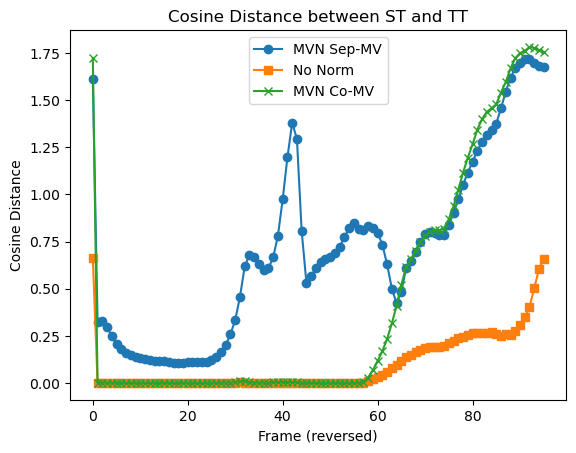

In [158]:
picked_idx = random.randint(0, len(st_guide)-1)

st_audio = get_audio_st(st_guide.iloc[picked_idx]["pre_path"], st_guide.iloc[picked_idx]["stop_path"], st_guide.iloc[picked_idx]["vowel_path"])
tt_audio = get_audio_tt(noise_set[picked_idx], st_guide.iloc[picked_idx]["stop_path"], st_guide.iloc[picked_idx]["vowel_path"])


st_spec_nonorm = mytrans_nonorm(st_audio)
tt_spec_nonorm = mytrans_nonorm(tt_audio)

mean, std = mv_get(st_spec_nonorm)
st_spec_newnorm = norm_mvn_manual(st_spec_nonorm, mean, std)
tt_spec_newnorm = norm_mvn_manual(tt_spec_nonorm, mean, std)

st_spec = norm_mvn(st_spec_nonorm)
tt_spec = norm_mvn(tt_spec_nonorm)


dist_list = []
dist_list_nonorm = []
dist_list_newnorm = []
for i in range(min(len(st_spec), len(tt_spec))):
    dist_list.append(cosine(st_spec[-i], tt_spec[-i]))
    dist_list_nonorm.append(cosine(st_spec_nonorm[-i], tt_spec_nonorm[-i]))
    dist_list_newnorm.append(cosine(st_spec_newnorm[-i], tt_spec_newnorm[-i]))

import matplotlib.pyplot as plt

# Sample data for two groups
x_values = range(len(dist_list))

# Plotting the line graph
plt.plot(x_values, dist_list, label='MVN Sep-MV', marker='o')
plt.plot(x_values, dist_list_nonorm, label='No Norm', marker='s')
plt.plot(x_values, dist_list_newnorm, label='MVN Co-MV', marker='x')

# Adding title and labels
plt.title('Cosine Distance between ST and TT')
plt.xlabel('Frame (reversed)')
plt.ylabel('Cosine Distance')

# Adding legend to distinguish between the two groups
plt.legend()

# Display the graph
plt.show()
